In [9]:
!pip3 install torch torchvision

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import copy
# (0.1307,), (0.3081,)

# Data Preparation

In [11]:
# using pretrained means to normalize the dataset
pretrained_means = [0.4914, 0.4822, 0.4465]
pretrained_stds= [0.247, 0.243, 0.261]
BATCH_SIZE = 100

# define tranforms on the training set
# include resizing and horizontal flip
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = pretrained_means,
                                                     std = pretrained_stds)])
# load the data
train = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

# percentage of the training data to be used in training
TRAIN_VAL_RATIO = 0.90

n_train_examples = int(len(train) * TRAIN_VAL_RATIO)
n_valid_examples = len(train) - n_train_examples

train, val = torch.utils.data.random_split(train, [n_train_examples, n_valid_examples])

# applying the transform on validation set
val = copy.deepcopy(val)
val.dataset.transform = transform

# defining appropriate dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


# VGG Architectures

In [0]:

# dictionary with model architectures, to define VGG19 simply add it to the dict
VGG_architectures = {
    'VGG13': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 'pool', 512, 512, 'pool', 512, 512, 'pool'],
    'VGG16': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 256, 'pool', 512, 512, 512, 'pool', 512, 512, 512, 'pool']
}

class VGG(nn.Module):
  '''
  Implementation of VGG with Batch Norm for MNIST and CIFAR

  num_classes (int): number of existing classes in data
  '''
  def __init__(self, in_planes = 1, num_classes = 10):
    super(VGG, self).__init__()
    self.in_planes = in_planes
    # using the stack layers function - define which architecture the model should use
    self.convs = self.stack_layers(VGG_architectures['VGG13'])

    # after Conv layers in the original VGG the output is 7x7, hence 
    # the input size for the FC layers should be 512x7x7 and output is 4096
    # CIFAR10 is 32x32, so this is my adaptation of VGG for CIFAR
    self.fully_connected = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )

  def stack_layers(self, architecture):
    in_planes = self.in_planes
    # initialize empty list for all layers to be added
    stack = []

    for layer in architecture:
      if type(layer) == int:
        out = layer
        stack += [nn.Conv2d(in_planes, out, kernel_size = 3, stride = 1, padding = 1),
                  # use Batch Normalization here
                  nn.BatchNorm2d(layer),
                  nn.ReLU(inplace = True)]
        in_planes = layer
      else:
        stack += [nn.MaxPool2d(kernel_size = 2)]
      
    return nn.Sequential(*stack)

  def forward(self, x):
    # bringing together all parts of the network here
    x = self.convs(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fully_connected(x)

    return x


# ResNet Architectures

In [0]:
class ResNetBlock(nn.Module):
    '''
    A class for a Basic ResNet Block to be used in the ResNet class
    Suited only for CIFAR10 and MNIST
    Defined according to 4.2 of the ResNet paper

    in_planes (int): number of input channels
    planes (int): number of output channels
    stride (int): stride of the convolutional layer
    '''
    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(planes)
              )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        
class ResNet(nn.Module):
    '''
    ResNet Class, building on a ResNet Block to make a full network

    num_blocks (int):       multiplier used to stack layers, 
                            total number of layers is 6*num_blocks + 2
    channels (int):         number of colour_channels present in data
    num_classes (int):      number of existing classes in data
    '''
    def __init__(self, block, num_blocks, channels, num_classes):
        super(ResNet, self).__init__()
        # initialize number of output channels at 16
        self.in_planes = 16

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.stack_layer(block, 16, num_blocks, stride=1)
        self.layer2 = self.stack_layer(block, 32, num_blocks, stride=2)
        self.layer3 = self.stack_layer(block, 64, num_blocks, stride=2)
        self.linear = nn.Linear(64, num_classes)
    
    def stack_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            # update the number of output channels
            self.in_planes = planes 

        return nn.Sequential(*layers)

    def forward(self, x):
        # creating the network
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        # reshaping
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def resnet20():
    return ResNet(ResNetBlock, num_blocks = 3, channels = 3, num_classes = 10)


def resnet44():
    return ResNet(ResNetBlock, num_blocks = 7, channels = 3, num_classes = 10)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# umcomment a model to use here
#model = VGG(in_planes=3,num_classes=10).to(device)
model = resnet20().to(device)
#model = resnet44().to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay=0.0001)
# scheduler for VGG
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10], last_epoch= -1)
# scheduler for ResNet
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[100, 150], last_epoch= -1)

In [16]:
def calculate_accuracy(y_pred, y):
    '''get model accuracy'''
    p = y_pred.argmax(1, keepdim = True)
    acc = p.eq(y.view_as(p)).sum().float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    '''
    function to be called for training and collect 
    model loss and model accuracy
    and perform a training step

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # set to training mode
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        # update loss and accuracy values
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    '''
    function to be called for evaluating and collect 
    model val loss and model val accuracy

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # evaluation mode
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

EPOCHS = 20
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []
for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'epoch: {epoch+1:02}, Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t train accuracy: {train_acc:.3f} | train loss: {train_loss:.3f} | ')
    print(f'\t val accuracy: {val_acc:.3f} | val accuracy: {val_loss:.3f}')

epoch: 01, Time: 0m 45s
	 train accuracy: 0.451 | train loss: 1.474 | 
	 val accuracy: 0.522 | val accuracy: 1.301
epoch: 02, Time: 0m 44s
	 train accuracy: 0.638 | train loss: 1.003 | 
	 val accuracy: 0.622 | val accuracy: 1.050
epoch: 03, Time: 0m 44s
	 train accuracy: 0.715 | train loss: 0.806 | 
	 val accuracy: 0.699 | val accuracy: 0.848
epoch: 04, Time: 0m 44s
	 train accuracy: 0.762 | train loss: 0.685 | 
	 val accuracy: 0.734 | val accuracy: 0.776
epoch: 05, Time: 0m 45s
	 train accuracy: 0.787 | train loss: 0.612 | 
	 val accuracy: 0.751 | val accuracy: 0.725
epoch: 06, Time: 0m 44s
	 train accuracy: 0.810 | train loss: 0.549 | 
	 val accuracy: 0.783 | val accuracy: 0.619
epoch: 07, Time: 0m 45s
	 train accuracy: 0.826 | train loss: 0.507 | 
	 val accuracy: 0.766 | val accuracy: 0.677
epoch: 08, Time: 0m 44s
	 train accuracy: 0.837 | train loss: 0.470 | 
	 val accuracy: 0.790 | val accuracy: 0.596
epoch: 09, Time: 0m 45s
	 train accuracy: 0.848 | train loss: 0.441 | 
	 val acc

In [0]:
def get_preds(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [0]:
images, labels, probs = get_preds(model, test_loader)
pred_labels = torch.argmax(probs, 1)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

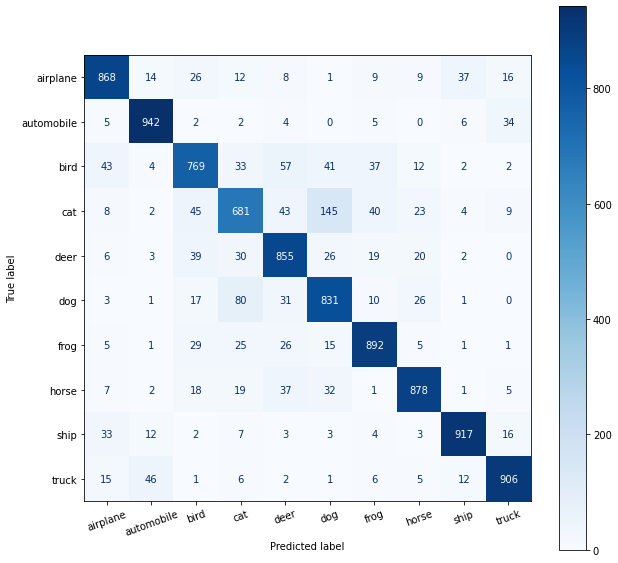

In [20]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'VGG13, Cross Entropy Loss across Epochs')

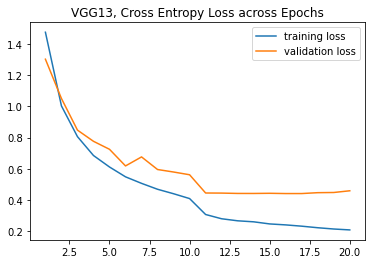

In [21]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list, label = 'validation loss')
plt.legend()
plt.title('VGG13, Cross Entropy Loss across Epochs')

Text(0.5, 1.0, 'VGG13, Accuracy across Epochs')

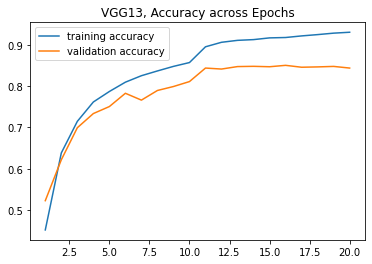

In [22]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list, label = 'validation accuracy')
plt.legend()
plt.title('VGG13, Accuracy across Epochs')

In [0]:
def labels_accuracy(y, y_pred):
  crr = 0
  for i in range(len(y)):
    if y[i] == y_pred[i]:
      crr += 1
  return crr/len(y)

In [24]:
labels_accuracy(labels.numpy(), pred_labels.numpy())

0.8539

In [0]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [0]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

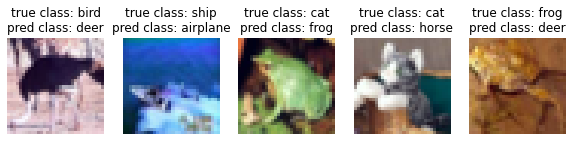

In [27]:
def show_incorrect_preds(incorrect, classes, n_images, normalize = True):

    rows = 1
    cols = n_images 

    fig = plt.figure(figsize = (10, 10))
    fig.tight_layout()
    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true class: {true_class}\n' \
                     f'pred class: {incorrect_class}')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.0)

show_incorrect_preds(incorrect_examples, classes, 5)